In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D, LSTM

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data_dnndr/final_clean_DTI.csv')
mapping = pd.read_csv('data_dnndr/chembl2uniprot.txt', header=None, sep='\t')
targets = os.listdir('data_dnndr/fasta_files')

In [3]:
data = pd.DataFrame(columns=['target','seq'])
for fasta in tqdm(targets):
    f = open('data_dnndr/fasta_files/'+fasta,'r')
    lines = "".join(line.strip() for line in f.readlines()[1:])
    dict = {'target':fasta.split('.')[0], 'seq':lines}
    data = data.append(dict, True)

100%|██████████| 1685/1685 [00:03<00:00, 449.94it/s]


In [4]:
# Length of sequence in train data.
data['seq_char_count']= data['seq'].apply(lambda x: len(x))

In [27]:
def plot_seq_count(df, data_name):
    sns.distplot(df['seq_char_count'].values)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

def get_code_freq(df, data_name):
    df = df.apply(lambda x: " ".join(x))
    codes = []
    for i in df: # concatination of all codes
        codes.extend(i)
    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space

    print(f'Codes: {data_name}')
    print(f'Total unique codes: {len(codes_dict.keys())}')

    df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
    return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

def plot_code_freq(df, data_name):
    plt.title(f'Code frequency: {data_name}')
    sns.barplot(x='Code', y='Freq', data=df)
    plt.grid(True)

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1
    return char_dict

def integer_encoding(data):
    """
    - Encodes code sequence to integer values.
    - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
    """
    encode_list = []
    for row in data['seq'].values:
        row_encode = []
        for code in row:
            row_encode.append(char_dict.get(code, 0))
        encode_list.append(np.array(row_encode))
    return encode_list

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.grid()

def display_model_score(model, train, val, test, batch_size):

    train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
    print('Train loss: ', train_score[0])
    print('Train accuracy: ', train_score[1])
    print('-'*70)

    val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
    print('Val loss: ', val_score[0])
    print('Val accuracy: ', val_score[1])
    print('-'*70)

    test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
    print('Test loss: ', test_score[0])
    print('Test accuracy: ', test_score[1])

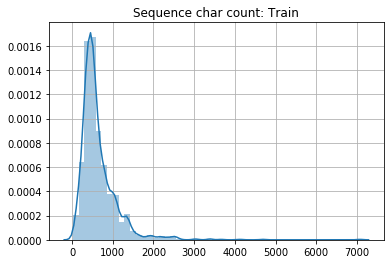

In [6]:
plt.subplot(1, 1, 1)
plot_seq_count(data, 'Train')

Codes: Train
Total unique codes: 22


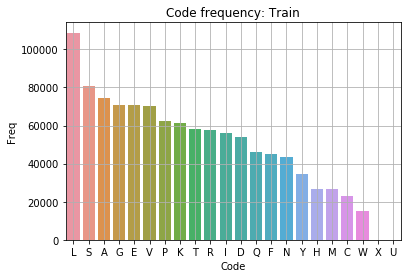

In [7]:
code_freq = get_code_freq(data['seq'], 'Train')

plt.subplot(1, 1, 1)
plot_code_freq(code_freq, 'Train')

In [8]:

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length:20


In [9]:
train_encode = integer_encoding(data) 

In [10]:
# padding sequences
max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
train_pad.shape

(1685, 100)

In [11]:
# One hot encoding of sequences
train_ohe = to_categorical(train_pad)
train_ohe.shape

(1685, 100, 21)

In [12]:
import random
list = ['c1', 'c2', 'c3']
c = []
for i in range(1685):
    c.append(random.choice(list))

In [13]:
# label/integer encoding output variable: (y)
le = LabelEncoder()
y_train_le = le.fit_transform(c)
y_train_le.shape

(1685,)

In [14]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_train.shape

(1685, 3)

In [38]:
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W = self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b = self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [41]:
x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input) 

conv_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(emb)
pool_1 = MaxPooling1D(pool_size=2)(conv_1)

att_in = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(pool_1)
att_out = attention()(att_in)

# softmax classifier
x_output = Dense(3, activation='softmax')(att_out)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
input_8 (InputLayer)         (None, 100)               0
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 128)          2688
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 32)           12320
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 128)           49664
_________________________________________________________________
attention_2 (attention)      (None, 128)               178
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387
Total params: 65,237
Trainable params: 65,23

In [47]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history1 = model1.fit(
    train_pad, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2,
    callbacks=[es]
    )

...] - ETA: 1s - loss: 1.0566 - accuracy: 0.43 832/1348 [=================>............] - ETA: 1s - loss: 1.0573 - accuracy: 0.43 864/1348 [==================>...........] - ETA: 1s - loss: 1.0576 - accuracy: 0.43 896/1348 [==================>...........] - ETA: 1s - loss: 1.0574 - accuracy: 0.43 928/1348 [===================>..........] - ETA: 1s - loss: 1.0592 - accuracy: 0.43 960/1348 [====================>.........] - ETA: 1s - loss: 1.0644 - accuracy: 0.43 992/1348 [=====================>........] - ETA: 0s - loss: 1.0652 - accuracy: 0.431024/1348 [=====================>........] - ETA: 0s - loss: 1.0678 - accuracy: 0.431056/1348 [======================>.......] - ETA: 0s - loss: 1.0693 - accuracy: 0.421088/1348 [=======================>......] - ETA: 0s - loss: 1.0679 - accuracy: 0.431120/1348 [=======================>......] - ETA: 0s - loss: 1.0676 - accuracy: 0.431152/1348 [========================>.....] - ETA: 0s - loss: 1.0656 - accuracy: 0.431184/1348 [===================

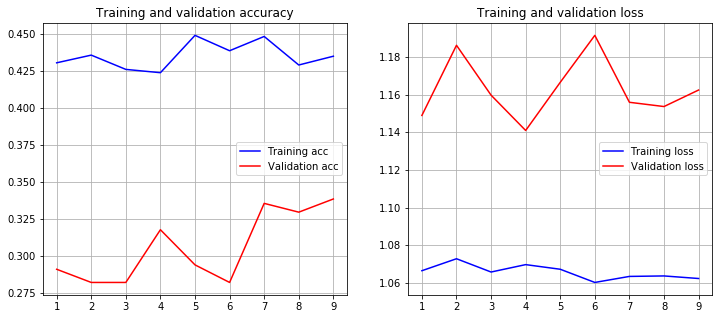

In [49]:
plot_history(history1)

In [23]:
for a in history1.history:
    print(a)

val_loss
val_accuracy
loss
accuracy
